# **Practica 3.0 Regresión lineal en contexto de series de tiempo.**

**Carrera:** Licenciatura en Ciencia de Datos

**Grupo:**  6AV1

**Materia:** Análisis de Series de Tiempo

**Docente:** Daniel Jiménez Alcantar

**Alumno:**  
* Aguilar Ramirez Carlos Francisco
* Arista Romero Juan Ismael
* Jiménez Flores Luis Arturo
* Vazquez Martin Marlene Gabriela


Fecha de última modificación: 14/03/2025

In [1]:
import pandas as pd

# Subir el archivo a Google Colab
from google.colab import files

uploaded = files.upload()

file_name = "/content/spotify-2023.csv"

# Cargar el dataset con la codificación correcta
df = pd.read_csv(file_name, encoding="latin1")

# Convertir columnas de fecha en un solo campo de tipo datetime
df['release_date'] = pd.to_datetime(df[['released_year', 'released_month', 'released_day']]
                                    .astype(str)
                                    .agg('-'.join, axis=1), errors='coerce')

# Seleccionar solo las columnas relevantes
df_time_series = df[['release_date', 'streams']].dropna()

# Ordenar por fecha
df_time_series = df_time_series.sort_values(by='release_date')

# Mostrar las primeras filas
df_time_series.head()


Saving spotify-2023.csv to spotify-2023 (1).csv


,release_date,streams
439,1930-01-01,90598517
469,1942-01-01,395591396
460,1946-11-01,389771964
466,1950-01-01,473248298
459,1952-01-01,395591396


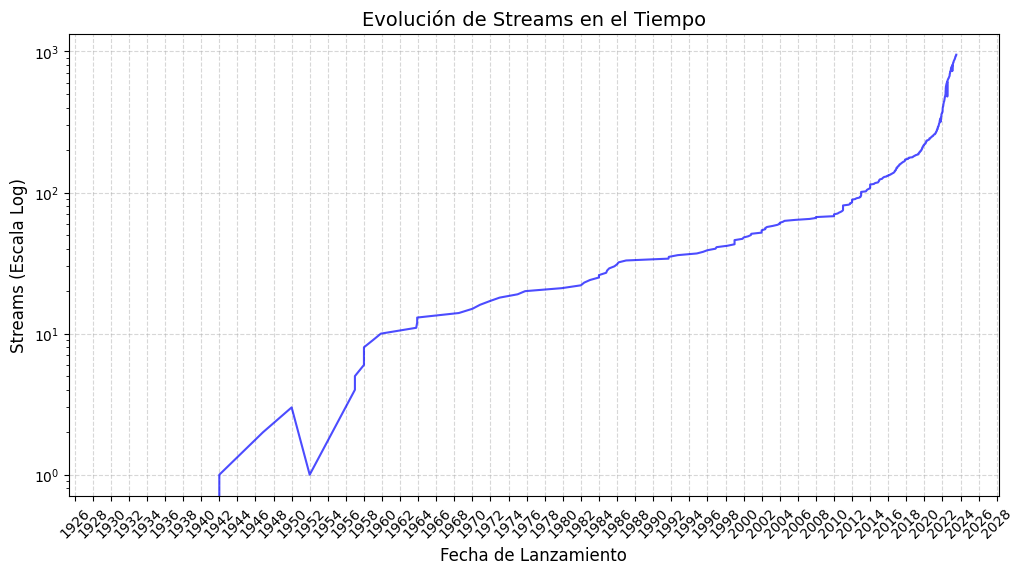

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convertir a datetime
df_time_series['release_date'] = pd.to_datetime(df_time_series['release_date'])

# Configurar la figura y el tamaño
plt.figure(figsize=(12,6))

# Graficar streams
plt.plot(df_time_series['release_date'], df_time_series['streams'], color='blue', alpha=0.7)

# Formatear ejes
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Mostrar etiquetas cada 2 años
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Formato de año

# Etiquetas y título
plt.xlabel("Fecha de Lanzamiento", fontsize=12)
plt.ylabel("Streams (Escala Log)", fontsize=12)
plt.title("Evolución de Streams en el Tiempo", fontsize=14)

# Aplicar escala logarítmica
plt.yscale("log")

# Rotar etiquetas del eje X
plt.xticks(rotation=45)

# Activar la cuadrícula
plt.grid(True, linestyle='--', alpha=0.5)

# Mostrar gráfico
plt.show()



## Prueba de Estacionaridad


In [4]:
from statsmodels.tsa.stattools import adfuller

# Verificar si la columna 'streams' tiene valores no numéricos
print("Tipos de datos en streams:")
print(df_time_series['streams'].apply(type).value_counts())

# Intentar convertir a número, forzando los errores a NaN para eliminarlos
df_time_series['streams'] = pd.to_numeric(df_time_series['streams'], errors='coerce')

# Eliminar filas con valores NaN (errores de conversión)
df_time_series = df_time_series.dropna(subset=['streams'])

# Aplicar la prueba de Dickey-Fuller nuevamente
result = adfuller(df_time_series['streams'])

# Mostrar resultados
print("Prueba de Dickey-Fuller Aumentada:")
print(f"Estadístico ADF: {result[0]}")
print(f"p-valor: {result[1]}")
print(f"Valores Críticos:")
for key, value in result[4].items():
    print(f"   {key}: {value}")

# Interpretación
if result[1] < 0.05:
    print("\nLa serie es estacionaria (rechazamos la hipótesis nula).")
else:
    print("\nLa serie NO es estacionaria (no podemos rechazar la hipótesis nula).")



Tipos de datos en streams:
streams
<class 'float'>    952
Name: count, dtype: int64
Prueba de Dickey-Fuller Aumentada:
Estadístico ADF: -1.180334659373123
p-valor: 0.68199752658574
Valores Críticos:
   1%: -3.4374086231752226
   5%: -2.864656150681263
   10%: -2.568429228935821

La serie NO es estacionaria (no podemos rechazar la hipótesis nula).


In [5]:
# Aplicar la diferenciación de primer orden
df_time_series['streams_diff'] = df_time_series['streams'].diff().dropna()

# Eliminar los valores NaN generados por la diferenciación
df_time_series = df_time_series.dropna()

# Aplicar nuevamente la prueba de Dickey-Fuller
result_diff = adfuller(df_time_series['streams_diff'])

# Mostrar resultados
print("Prueba de Dickey-Fuller Aumentada (después de diferenciación):")
print(f"Estadístico ADF: {result_diff[0]}")
print(f"p-valor: {result_diff[1]}")
print(f"Valores Críticos:")
for key, value in result_diff[4].items():
    print(f"   {key}: {value}")

# Interpretación
if result_diff[1] < 0.05:
    print("\nLa serie es estacionaria.")
else:
    print("\nLa serie sigue sin ser estacionaria.")


Prueba de Dickey-Fuller Aumentada (después de diferenciación):
Estadístico ADF: -12.195523243999434
p-valor: 1.2571732156328779e-22
Valores Críticos:
   1%: -3.4374086231752226
   5%: -2.864656150681263
   10%: -2.568429228935821

La serie es estacionaria.


## Regresión Lineal

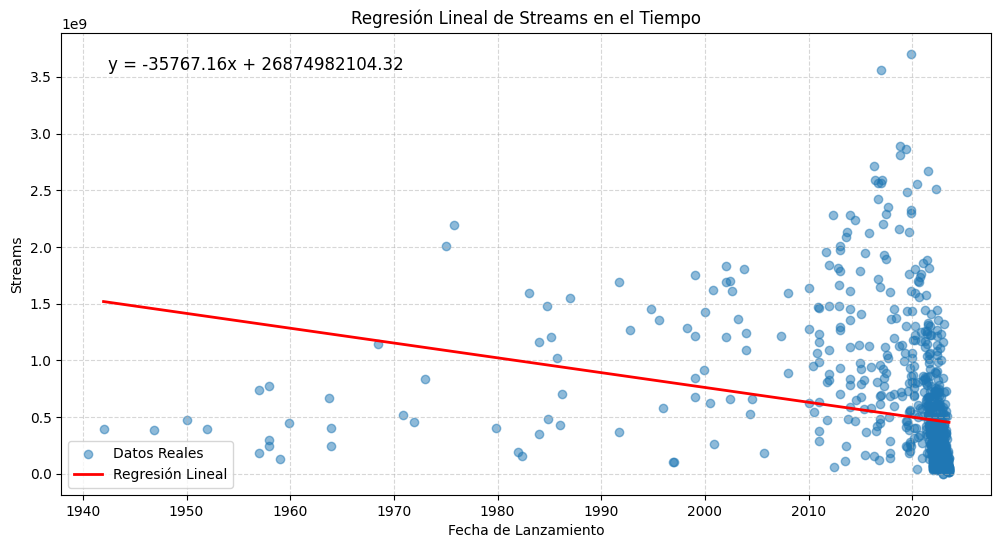

                            OLS Regression Results                            
Dep. Variable:                streams   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     60.97
Date:                Sat, 15 Mar 2025   Prob (F-statistic):           1.53e-14
Time:                        00:50:15   Log-Likelihood:                -20488.
No. Observations:                 951   AIC:                         4.098e+04
Df Residuals:                     949   BIC:                         4.099e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2.687e+10   3.38e+09      7.961   

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Convertir la fecha en un número ordinal
df_time_series['date_ordinal'] = df_time_series['release_date'].map(lambda x: x.toordinal())

# Definir variables para regresión
X = df_time_series['date_ordinal']  # Variable independiente (fecha)
y = df_time_series['streams']       # Variable dependiente (streams)

# Agregar una constante para la intersección en la regresión
X = sm.add_constant(X)

# Ajustar el modelo de regresión lineal
model = sm.OLS(y, X).fit()

# Obtener la línea de tendencia
df_time_series['trend'] = model.predict(X)

# Graficar los datos originales y la regresión
plt.figure(figsize=(12, 6))
plt.scatter(df_time_series['release_date'], df_time_series['streams'], label="Datos Reales", alpha=0.5)
plt.plot(df_time_series['release_date'], df_time_series['trend'], color='red', linewidth=2, label="Regresión Lineal")

# Etiquetas y título
plt.xlabel("Fecha de Lanzamiento")
plt.ylabel("Streams")
plt.title("Regresión Lineal de Streams en el Tiempo")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

# Agregar la ecuación de la regresión al gráfico
slope = model.params['date_ordinal']
intercept = model.params['const']
equation = f'y = {slope:.2f}x + {intercept:.2f}'  # Formatear la ecuación
plt.text(0.05, 0.95, equation, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')  # Agregar el texto al gráfico

# Mostrar el gráfico
plt.show()

# Mostrar resultados del modelo
print(model.summary())

## Regresión con Transformación Logarítmica

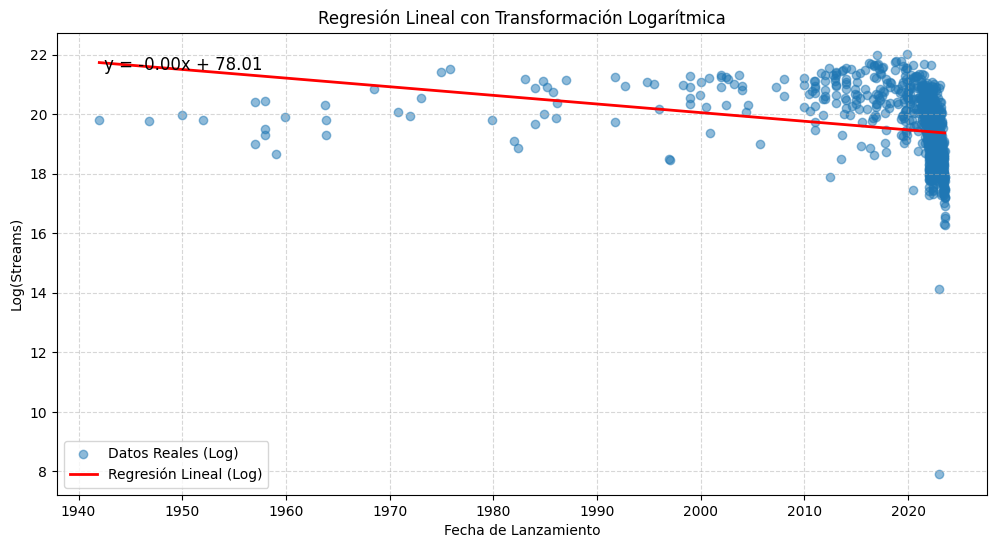

                            OLS Regression Results                            
Dep. Variable:            log_streams   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     74.46
Date:                Sat, 15 Mar 2025   Prob (F-statistic):           2.58e-17
Time:                        00:51:45   Log-Likelihood:                -1442.8
No. Observations:                 951   AIC:                             2890.
Df Residuals:                     949   BIC:                             2899.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           78.0073      6.780     11.506   

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Aplicar transformación logarítmica a los streams
df_time_series['log_streams'] = np.log1p(df_time_series['streams'])

# Definir variables para regresión
X = df_time_series['date_ordinal']
y = df_time_series['log_streams']

# Agregar una constante para la intersección
X = sm.add_constant(X)

# Ajustar modelo de regresión
model_log = sm.OLS(y, X).fit()

# Obtener la nueva tendencia
df_time_series['log_trend'] = model_log.predict(X)

# Graficar los datos con la transformación logarítmica
plt.figure(figsize=(12, 6))
plt.scatter(df_time_series['release_date'], df_time_series['log_streams'], label="Datos Reales (Log)", alpha=0.5)
plt.plot(df_time_series['release_date'], df_time_series['log_trend'], color='red', linewidth=2, label="Regresión Lineal (Log)")

# Etiquetas y título
plt.xlabel("Fecha de Lanzamiento")
plt.ylabel("Log(Streams)")
plt.title("Regresión Lineal con Transformación Logarítmica")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

# Agregar la ecuación de la regresión al gráfico
slope_log = model_log.params['date_ordinal']
intercept_log = model_log.params['const']
equation_log = f'y = {slope_log:.2f}x + {intercept_log:.2f}'
plt.text(0.05, 0.95, equation_log, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

# Mostrar el gráfico
plt.show()

# Mostrar los resultados del modelo
print(model_log.summary())


## Modelo ARIMA

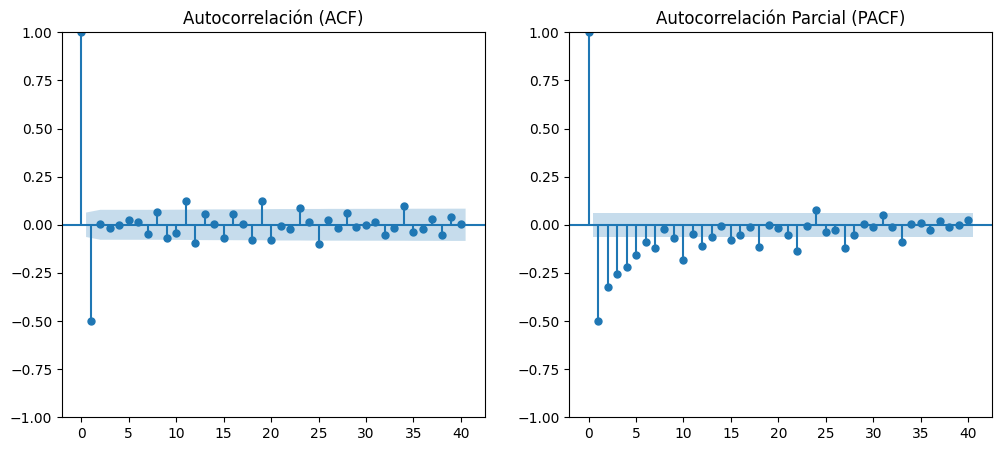

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Graficar ACF y PACF para determinar p y q
fig, ax = plt.subplots(1, 2, figsize=(12,5))

# ACF (Autocorrelación)
plot_acf(df_time_series['streams_diff'], ax=ax[0], lags=40)
ax[0].set_title("Autocorrelación (ACF)")

# PACF (Autocorrelación Parcial)
plot_pacf(df_time_series['streams_diff'], ax=ax[1], lags=40)
ax[1].set_title("Autocorrelación Parcial (PACF)")

plt.show()


In [9]:
from statsmodels.tsa.arima.model import ARIMA

# Definir el modelo ARIMA con los valores obtenidos
model_arima = ARIMA(df_time_series['streams'], order=(1,1,1))

# Ajustar el modelo
arima_result = model_arima.fit()

# Mostrar resumen del modelo
print(arima_result.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                streams   No. Observations:                  951
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -20239.543
Date:                Sat, 15 Mar 2025   AIC                          40485.087
Time:                        00:52:11   BIC                          40499.656
Sample:                             0   HQIC                         40490.638
                                - 951                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0055      0.023      0.242      0.809      -0.039       0.050
ma.L1         -0.9434      0.011    -84.375      0.000      -0.965      -0.922
sigma2      2.181e+17   2.73e-21      8e+37      0.0

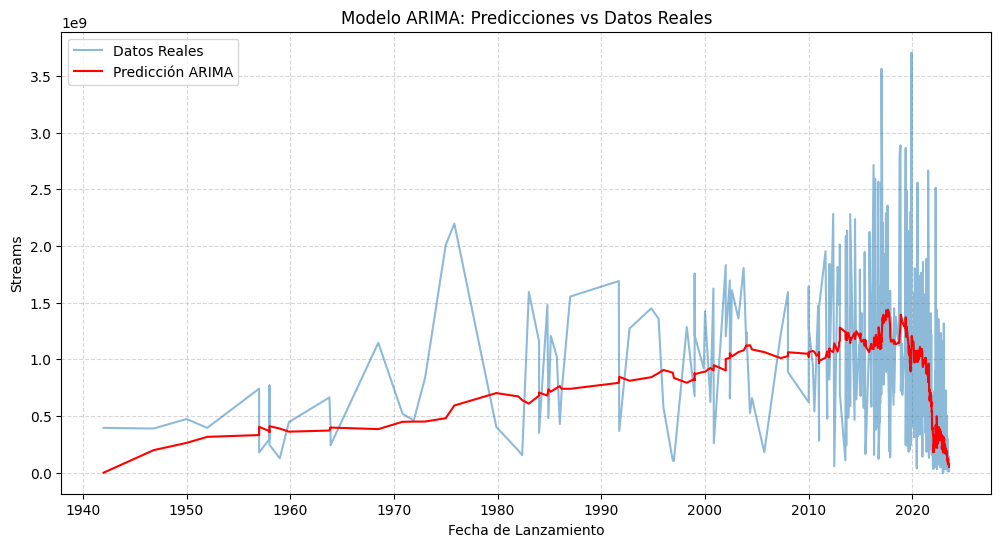

In [10]:
# Generar predicciones dentro del conjunto de datos
df_time_series['arima_pred'] = arima_result.predict()

# Graficar datos reales y predicciones
plt.figure(figsize=(12,6))
plt.plot(df_time_series['release_date'], df_time_series['streams'], label="Datos Reales", alpha=0.5)
plt.plot(df_time_series['release_date'], df_time_series['arima_pred'], color='red', label="Predicción ARIMA")

# Etiquetas y título
plt.xlabel("Fecha de Lanzamiento")
plt.ylabel("Streams")
plt.title("Modelo ARIMA: Predicciones vs Datos Reales")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

# Mostrar el gráfico
plt.show()


In [11]:
!pip install pmdarima
from pmdarima import auto_arima

# Encontrar los mejores parámetros automáticamente
auto_model = auto_arima(df_time_series['streams'], seasonal=False, trace=True, stepwise=True)

# Mostrar los mejores parámetros encontrados
print("Mejor modelo encontrado:", auto_model.order)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.4 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=40481.414, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=41068.166, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=40797.772, Time=0.08 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=40484.702, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=41066.166, Time=0.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=40479.541, Time=0.55 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=40478.769, Time=0.79 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=40479.778, Time=1.31 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=40486.674, Time=0.68 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=40480.916, Time=0.39 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0]             : AIC=40476.684, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=40483.110, Time=0.13 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0]             : AIC=40478.034, Time=0.22 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,0)[0]             : AIC=40477.367, Time=0.34 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=40485.087, Time=0.25 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[0]             : AIC=40479.295, Time=0.35 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 5.967 seconds
Mejor modelo encontrado: (0, 1, 2)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                streams   No. Observations:                  951
Model:                 ARIMA(0, 1, 2)   Log Likelihood              -20235.342
Date:                Sat, 15 Mar 2025   AIC                          40476.684
Time:                        00:52:38   BIC                          40491.253
Sample:                             0   HQIC                         40482.235
                                - 951                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9380      0.021    -44.553      0.000      -0.979      -0.897
ma.L2         -0.0052      0.020     -0.259      0.796      -0.045       0.034
sigma2      2.028e+17   1.28e-20   1.58e+37      0.0

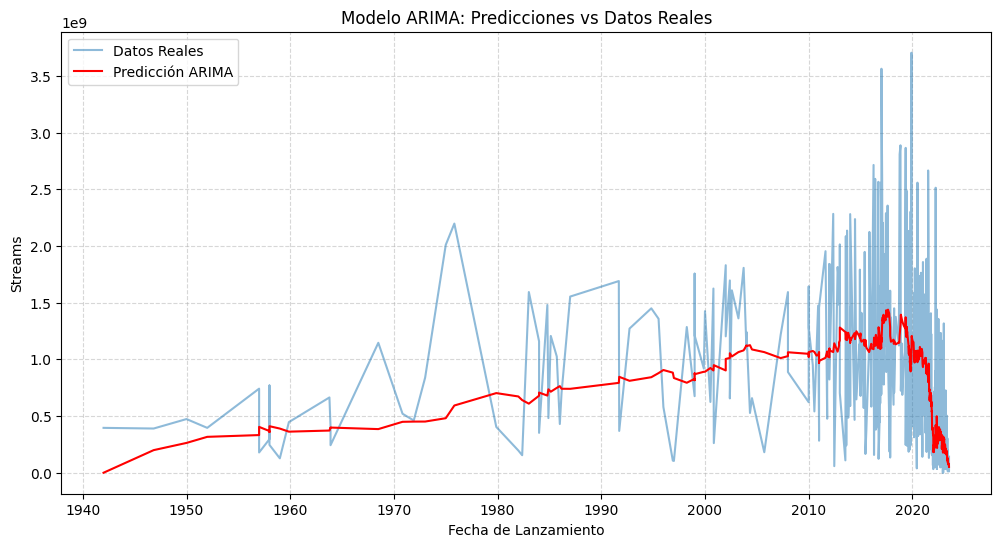

In [12]:
from statsmodels.tsa.arima.model import ARIMA

# Definir el modelo ARIMA con los valores obtenidos
model_arima = ARIMA(df_time_series['streams'], order=(0,1,2))

# Ajustar el modelo
arima_result = model_arima.fit()

# Mostrar resumen del modelo
print(arima_result.summary())

# Generar predicciones dentro del conjunto de datos
df_time_series['arima_pred'] = arima_result.predict()

# Graficar datos reales y predicciones
plt.figure(figsize=(12,6))
plt.plot(df_time_series['release_date'], df_time_series['streams'], label="Datos Reales", alpha=0.5)
plt.plot(df_time_series['release_date'], df_time_series['arima_pred'], color='red', label="Predicción ARIMA")

# Etiquetas y título
plt.xlabel("Fecha de Lanzamiento")
plt.ylabel("Streams")
plt.title("Modelo ARIMA: Predicciones vs Datos Reales")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

# Mostrar el gráfico
plt.show()

## Analizar Estacionalidad
El modelo ARIMA no se acopló muy bien a nuestros datos reales, por lo que analizaremos la estacionalidad para ver si SARIMA puede trabajar mejor con este dataset

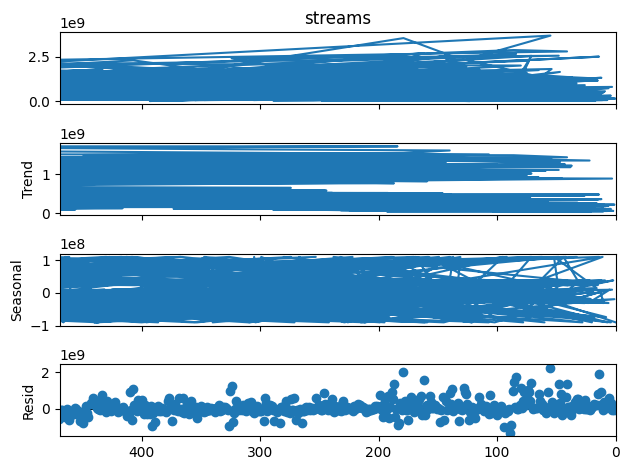

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomposición de la serie de tiempo para analizar estacionalidad
decomposition = seasonal_decompose(df_time_series['streams'], model='additive', period=12)

# Graficar la tendencia, estacionalidad y residuales
decomposition.plot()
plt.show()


In [14]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(df_time_series['streams'].dropna(), df_time_series['arima_pred'].dropna()))

print(f"Error RMSE del modelo ARIMA: {rmse}")


Error RMSE del modelo ARIMA: 429810488.4162128
